Load and inspect data

Combined Dataset Shape: (10299, 561)


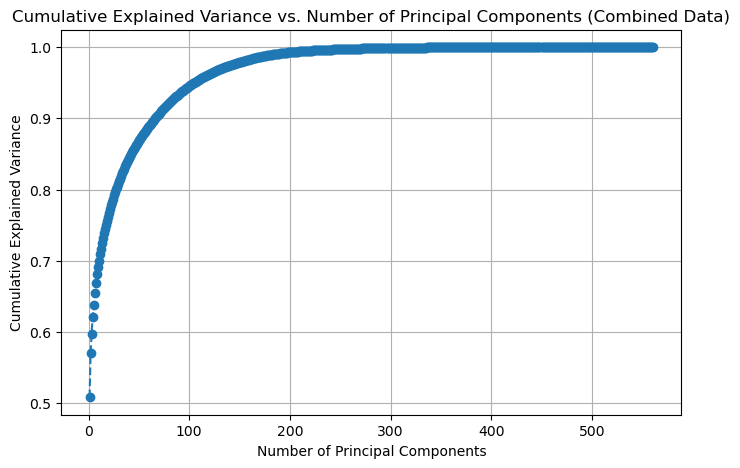

Optimal Number of Components to Retain ~99% Variance: 184
Reduced Combined Shape (99% Variance): (10299, 184)


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load the datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Drop 'subject' and separate features and labels
features_train = train.drop(columns=['Activity', 'subject'])
features_test = test.drop(columns=['Activity', 'subject'])
labels_train = train['Activity']
labels_test = test['Activity']

# Combine features and labels for a single dataset
combined_features = pd.concat([features_train, features_test], axis=0)
combined_labels = pd.concat([labels_train, labels_test], axis=0)

# Print original combined shapes
print(f"Combined Dataset Shape: {combined_features.shape}")

# Feature Engineering
def feature_engineering(data):
    # Add new statistical features
    data['tBodyAcc_mean_mag'] = np.sqrt(data['tBodyAcc-mean()-X']**2 + data['tBodyAcc-mean()-Y']**2 + data['tBodyAcc-mean()-Z']**2)
    data['tBodyAcc_std_mag'] = np.sqrt(data['tBodyAcc-std()-X']**2 + data['tBodyAcc-std()-Y']**2 + data['tBodyAcc-std()-Z']**2)
    
    # Min, max, and range
    data['tBodyAcc_range_X'] = data['tBodyAcc-max()-X'] - data['tBodyAcc-min()-X']
    data['tBodyAcc_range_Y'] = data['tBodyAcc-max()-Y'] - data['tBodyAcc-min()-Y']
    data['tBodyAcc_range_Z'] = data['tBodyAcc-max()-Z'] - data['tBodyAcc-min()-Z']
    
    # Add interaction terms
    data['tBodyAcc_Gyro_mean_product'] = (
        data['tBodyAcc-mean()-X'] * data['tBodyGyro-mean()-X'] +
        data['tBodyAcc-mean()-Y'] * data['tBodyGyro-mean()-Y'] +
        data['tBodyAcc-mean()-Z'] * data['tBodyGyro-mean()-Z']
    )
    
    # Add ratios
    data['tBodyAcc_max_min_ratio_X'] = data['tBodyAcc-max()-X'] / (data['tBodyAcc-min()-X'] + 1e-5)
    data['tBodyAcc_max_min_ratio_Y'] = data['tBodyAcc-max()-Y'] / (data['tBodyAcc-min()-Y'] + 1e-5)
    data['tBodyAcc_max_min_ratio_Z'] = data['tBodyAcc-max()-Z'] / (data['tBodyAcc-min()-Z'] + 1e-5)

    # Simplify angles
    if 'angle(tBodyAccMean,gravity)' in data.columns:
        data['angle_tBodyAcc_gravity'] = np.sqrt(
            data['angle(tBodyAccMean,gravity)']**2 + 
            data['angle(X,gravityMean)']**2 + 
            data['angle(Y,gravityMean)']**2
        )
        # Drop old features
        data.drop([
            'tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
            'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
            'angle(tBodyAccMean,gravity)', 'angle(X,gravityMean)', 
            'angle(Y,gravityMean)', 'angle(Z,gravityMean)'
        ], axis=1, inplace=True)

# Apply feature engineering
feature_engineering(combined_features)

# Scale the combined features
scaler = StandardScaler()
scaled_combined = scaler.fit_transform(combined_features)

# Fit PCA on the combined scaled data
pca_full = PCA()
pca_full.fit(scaled_combined)

# Calculate explained variance ratio
explained_variance_ratio = pca_full.explained_variance_ratio_
cumulative_variance_ratio = explained_variance_ratio.cumsum()

# Plot the cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--')
plt.title("Cumulative Explained Variance vs. Number of Principal Components (Combined Data)")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid()
plt.show()

# Function to calculate PCA for a given variance percentage
def apply_pca(data, explained_variance):
    optimal_components = (cumulative_variance_ratio >= explained_variance).argmax() + 1
    print(f"Optimal Number of Components to Retain ~{int(explained_variance * 100)}% Variance: {optimal_components}")
    pca = PCA(n_components=optimal_components)
    reduced_data = pca.fit_transform(data)
    print(f"Reduced Combined Shape ({int(explained_variance * 100)}% Variance): {reduced_data.shape}")
    return reduced_data

explained_variance_percentage = 0.99 
pca_combined = apply_pca(scaled_combined, explained_variance_percentage)


Clustering Technieques 
1) K-Means Clustering

c:\ProgramData\anaconda3\envs\new_mlds\lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\ProgramData\anaconda3\envs\new_mlds\lib\site-packages\joblib\externals\loky\backend\context.py", line 199, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\ProgramData\anaconda3\envs\new_mlds\lib\subprocess.py", line 493, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\ProgramData\anaconda3\envs\new_mlds\lib\subprocess.py", line 858, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\ProgramData\anaconda3\envs\new_mlds\lib\subprocess.py", line 1327, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePr

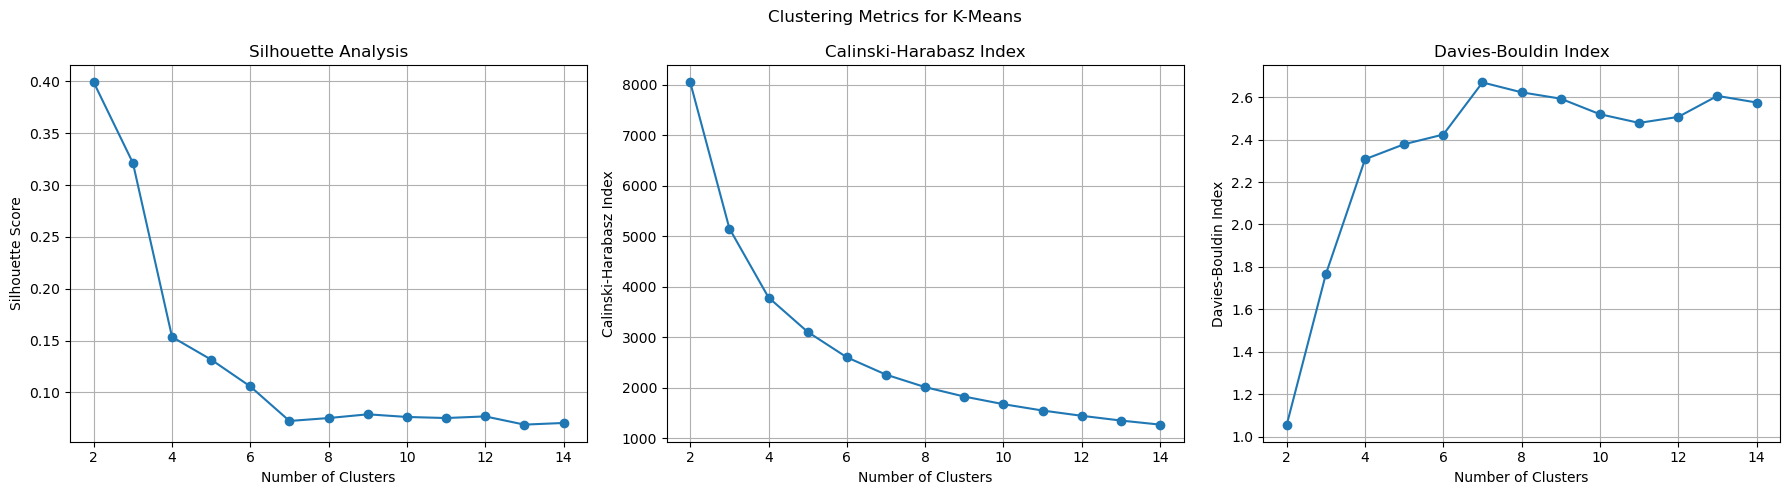

In [3]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Define the range of clusters
k_values = range(2, 15)

# Initialize a dictionary to store metrics
metrics = {'silhouette': [], 'calinski': [], 'davies_bouldin': []}

# Perform K-Means clustering on the PCA-reduced data
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
    kmeans.fit(pca_combined)  # Use the PCA-reduced data
    cluster_labels = kmeans.labels_
    metrics['silhouette'].append(silhouette_score(pca_combined, cluster_labels))
    metrics['calinski'].append(calinski_harabasz_score(pca_combined, cluster_labels))
    metrics['davies_bouldin'].append(davies_bouldin_score(pca_combined, cluster_labels))

# Plot the clustering metrics
plt.figure(figsize=(18, 5))
plt.suptitle("Clustering Metrics for K-Means")

# Plot Silhouette Scores
plt.subplot(1, 3, 1)
plt.plot(k_values, metrics['silhouette'], marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis")
plt.grid()

# Plot Calinski-Harabasz Index
plt.subplot(1, 3, 2)
plt.plot(k_values, metrics['calinski'], marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Calinski-Harabasz Index")
plt.title("Calinski-Harabasz Index")
plt.grid()

# Plot Davies-Bouldin Index
plt.subplot(1, 3, 3)
plt.plot(k_values, metrics['davies_bouldin'], marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Davies-Bouldin Index")
plt.title("Davies-Bouldin Index")
plt.grid()

plt.tight_layout()
plt.show()


EM

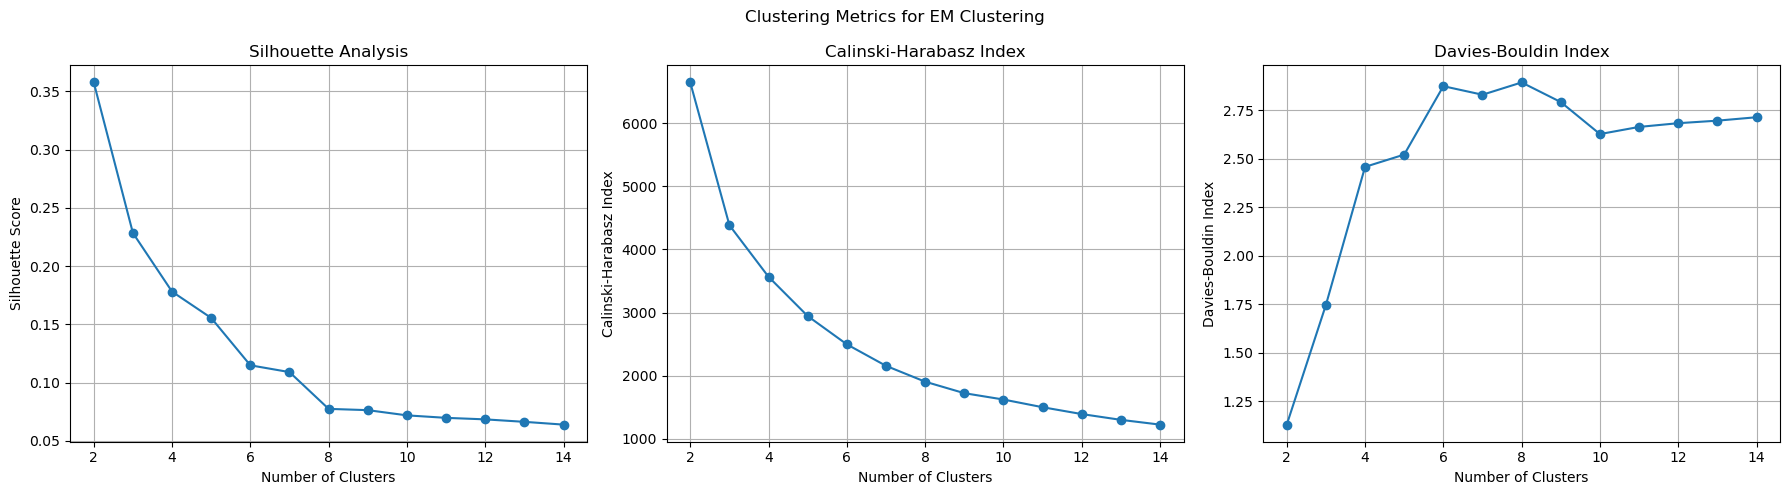

In [5]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt

# Function to perform EM clustering and calculate metrics
def perform_em_clustering(pca_data, k_values):
    metrics_em = {'silhouette': [], 'calinski': [], 'davies_bouldin': []}
    
    # EM clustering
    for k in k_values:
        gmm = GaussianMixture(n_components=k, random_state=42)
        gmm.fit(pca_data)
        cluster_labels = gmm.predict(pca_data)
        metrics_em['silhouette'].append(silhouette_score(pca_data, cluster_labels))
        metrics_em['calinski'].append(calinski_harabasz_score(pca_data, cluster_labels))
        metrics_em['davies_bouldin'].append(davies_bouldin_score(pca_data, cluster_labels))
    
    return metrics_em

# Define the range of clusters
k_values = range(2, 15)

# Perform clustering on the PCA-reduced data
metrics_em = perform_em_clustering(pca_combined, k_values)  

# Plot metrics for EM clustering
plt.figure(figsize=(18, 5))
plt.suptitle("Clustering Metrics for EM Clustering")

# Silhouette Analysis
plt.subplot(1, 3, 1)
plt.plot(k_values, metrics_em['silhouette'], marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis")
plt.grid()

# Calinski-Harabasz Index
plt.subplot(1, 3, 2)
plt.plot(k_values, metrics_em['calinski'], marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Calinski-Harabasz Index")
plt.title("Calinski-Harabasz Index")
plt.grid()

# Davies-Bouldin Index
plt.subplot(1, 3, 3)
plt.plot(k_values, metrics_em['davies_bouldin'], marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Davies-Bouldin Index")
plt.title("Davies-Bouldin Index")
plt.grid()

plt.tight_layout()
plt.show()


AgglomerativeClustering

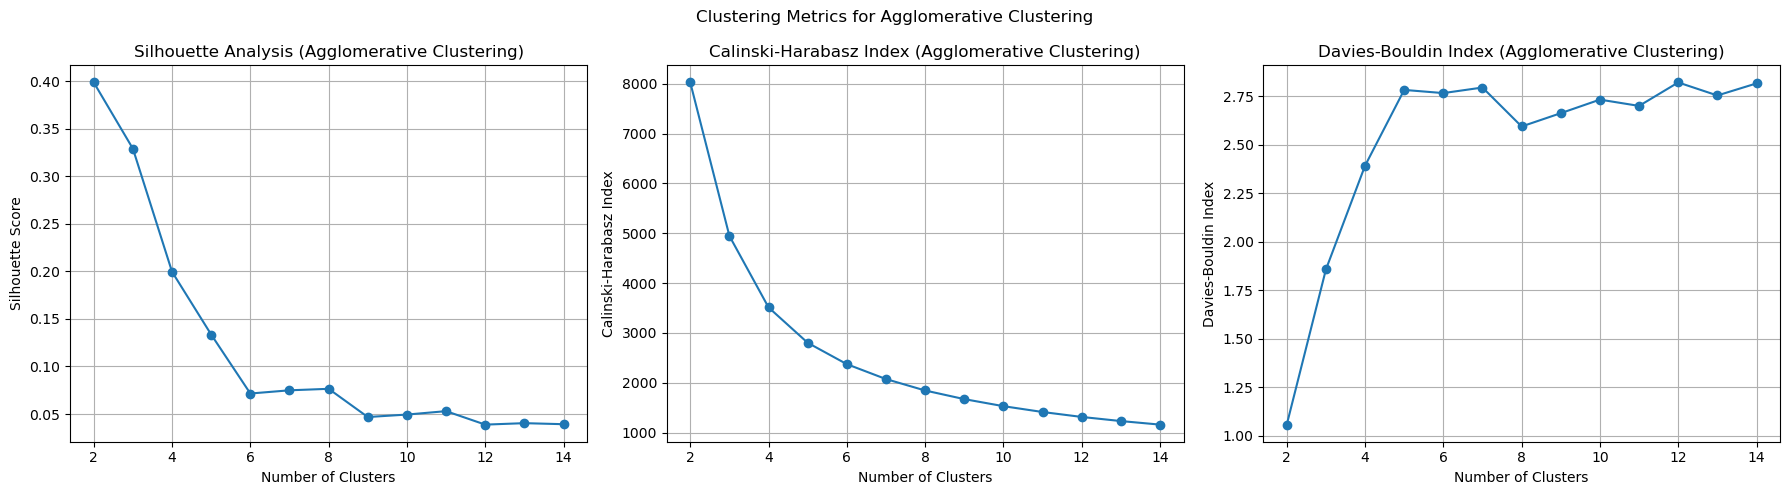

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Define the range of clusters
k_values = range(2, 15)

# Initialize a dictionary to store metrics for Agglomerative Clustering
agg_metrics = {'silhouette': [], 'calinski': [], 'davies_bouldin': []}

# Perform Agglomerative Clustering on the PCA-reduced data
for k in k_values:
    agg_clustering = AgglomerativeClustering(n_clusters=k)
    cluster_labels = agg_clustering.fit_predict(pca_combined)  # Use the PCA-reduced data
    agg_metrics['silhouette'].append(silhouette_score(pca_combined, cluster_labels))
    agg_metrics['calinski'].append(calinski_harabasz_score(pca_combined, cluster_labels))
    agg_metrics['davies_bouldin'].append(davies_bouldin_score(pca_combined, cluster_labels))

# Plot the clustering metrics for Agglomerative Clustering
plt.figure(figsize=(18, 5))
plt.suptitle("Clustering Metrics for Agglomerative Clustering")

# Plot Silhouette Scores
plt.subplot(1, 3, 1)
plt.plot(k_values, agg_metrics['silhouette'], marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis (Agglomerative Clustering)")
plt.grid()

# Plot Calinski-Harabasz Index
plt.subplot(1, 3, 2)
plt.plot(k_values, agg_metrics['calinski'], marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Calinski-Harabasz Index")
plt.title("Calinski-Harabasz Index (Agglomerative Clustering)")
plt.grid()

# Plot Davies-Bouldin Index
plt.subplot(1, 3, 3)
plt.plot(k_values, agg_metrics['davies_bouldin'], marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Davies-Bouldin Index")
plt.title("Davies-Bouldin Index (Agglomerative Clustering)")
plt.grid()

plt.tight_layout()
plt.show()


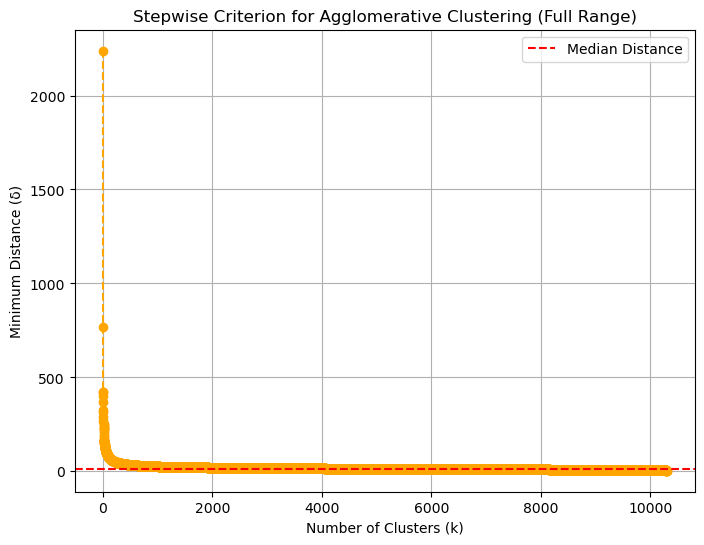

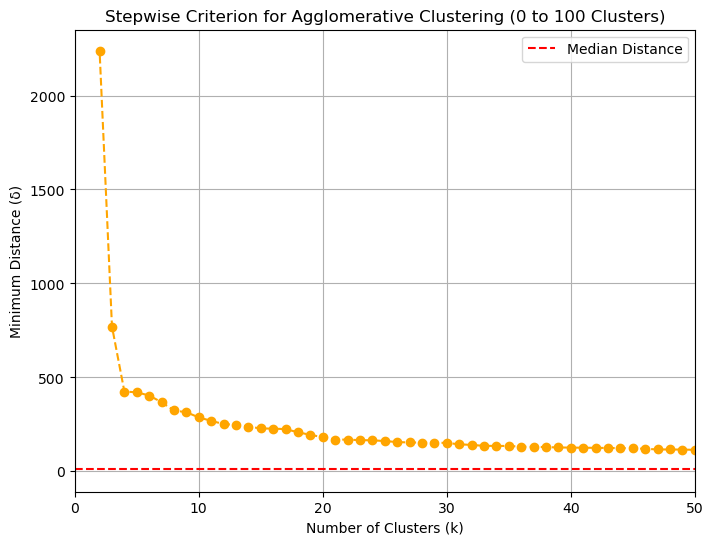

The optimal number of clusters (k*) is: 2


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage


# Perform hierarchical clustering using 'ward' linkage
linkage_matrix = linkage(pca_combined, method='ward')

# Extract the distances at each step
distances = linkage_matrix[:, 2]

# Generate the number of clusters (k) for each step
k_values = range(len(distances) + 1, 1, -1)  # From N clusters to 2 clusters

# Identify the optimal number of clusters based on the elbow method
optimal_k_index = np.argmax(np.diff(distances)) + 1  # Find the point with the maximum distance change
optimal_k = k_values[optimal_k_index]

# Plot the original stepwise criterion (entire range)
plt.figure(figsize=(8, 6))
plt.plot(k_values, distances, marker='o', linestyle='--', color='orange')
plt.title("Stepwise Criterion for Agglomerative Clustering (Full Range)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Minimum Distance (δ)")
plt.axhline(y=np.median(distances), color='r', linestyle='--', label='Median Distance')
plt.legend()
plt.grid()
plt.show()

# Plot the stepwise criterion for the range of clusters from 0 to 100
plt.figure(figsize=(8, 6))
plt.plot(k_values, distances, marker='o', linestyle='--', color='orange')
plt.title("Stepwise Criterion for Agglomerative Clustering (0 to 100 Clusters)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Minimum Distance (δ)")
plt.axhline(y=np.median(distances), color='r', linestyle='--', label='Median Distance')
plt.legend()
plt.grid()


plt.xlim(0, 50)
plt.show()

# Print the optimal number of clusters
print(f"The optimal number of clusters (k*) is: {optimal_k}")


PAM K-Medioid

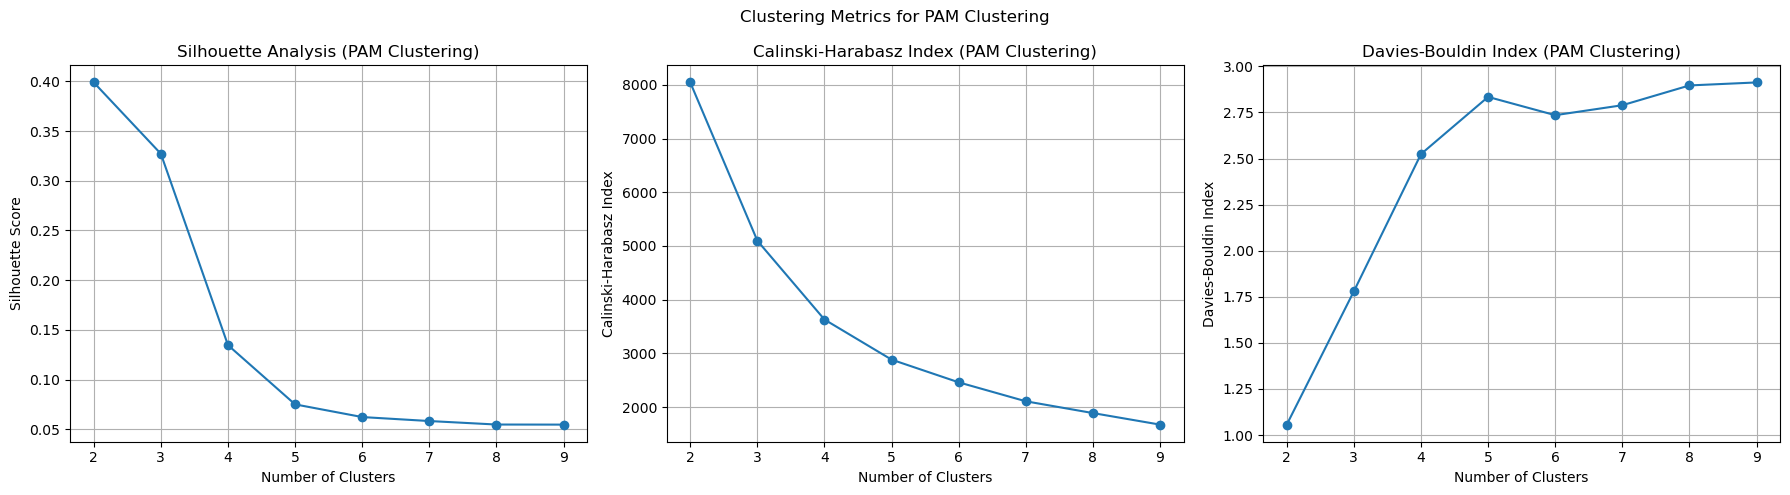

In [13]:
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt

# Function to perform PAM clustering and calculate metrics
def pam_clustering_metrics(pca_data, k_values):
    metrics_pam = {'silhouette': [], 'calinski': [], 'davies_bouldin': []}
    for k in k_values:
        kmedoids = KMedoids(n_clusters=k, random_state=42, method='pam')
        kmedoids.fit(pca_data)
        cluster_labels = kmedoids.labels_
        metrics_pam['silhouette'].append(silhouette_score(pca_data, cluster_labels))
        metrics_pam['calinski'].append(calinski_harabasz_score(pca_data, cluster_labels))
        metrics_pam['davies_bouldin'].append(davies_bouldin_score(pca_data, cluster_labels))
    return metrics_pam

# Define the range of clusters
k_values = range(2, 10)

# Perform PAM clustering for the PCA-reduced data
metrics_pam = pam_clustering_metrics(pca_combined, k_values) 

# Plot metrics for PAM clustering
plt.figure(figsize=(18, 5))
plt.suptitle("Clustering Metrics for PAM Clustering")

# Silhouette Score
plt.subplot(1, 3, 1)
plt.plot(k_values, metrics_pam['silhouette'], marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis (PAM Clustering)")
plt.grid()

# Calinski-Harabasz Index
plt.subplot(1, 3, 2)
plt.plot(k_values, metrics_pam['calinski'], marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Calinski-Harabasz Index")
plt.title("Calinski-Harabasz Index (PAM Clustering)")
plt.grid()

# Davies-Bouldin Index
plt.subplot(1, 3, 3)
plt.plot(k_values, metrics_pam['davies_bouldin'], marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Davies-Bouldin Index")
plt.title("Davies-Bouldin Index (PAM Clustering)")
plt.grid()

plt.tight_layout()
plt.show()
